# Determining Predictors of H-1B Salary and Approval (Project *DPH*)

## Project Documentation

**Contributors:**
- Wenhao Yu (netid: *wyu1*)
- Luke Duane (netid: *lduane*)
- Will Badart (netid: *wbadart*)

This project aims to provide meaningful analyses of the factors that drive H-1B visa approval, and provide insightful, tangential analyses which provide business value to enterprises sponsoring H-1B employees. The project has been excecuted for Notre Dame *CSE 40647/ 60647 - Data Science* as specified in the [project instructions](http://www.meng-jiang.com/teaching/CSE647Spring18-Project.pdf).

## Installation

Running the project requires [Python 3](https://www.python.org/downloads/release/python-365/). To install the project to your system as a package, as well as its dependencies, run:

    $ pip3 install git+https://github.com/wbadart/H-1B-Analyzer.git

(Remember the `--user` flag for systems on which you don't have administrative privileges.) This will also add the project's several entry points to your path, for running the individual analyses directly from the command line (see [Usage](#Usage)).

To uninstall, run:

    $ pip3 uninstall h1b

## Generating the Report

The source code of the report is available under [`docs/main.tex`](./docs/main.tex) if you need to compile it to anything other than a PDF. To compile, simple enter the documentation folder and run `make` (requires `pdflatex` to be installed and available on your `PATH`).

```
$ pwd
/path/to/H-1B-Analyzer
$ cd docs
$ make
```

Otherwise, the complete compiled report is already checked into the repository as [`docs/Determining Predictors of H-1B Salary and Approval.pdf`](./docs/Determining Predictors of H-1B Salary and Approval.pdf).

## Acquiring the Datasets

All the data used from this project is available for free from the Web (see the [final report](./docs/Determining Predictors of H-1B Salary and Approval.pdf), section 5.1 Datasets). It has been collected, archived, and been made available as a bundle at [wbadart.info/data.tar.gz](https://wbadart.info/data.tar.gz).

```
$ wget wbadart.info/data.tar.gz
...
$ tar xzf data.tar.gz
```

This will unpack the `data/` folder into the current directory. Within it will lie all of the pertinent data files expected by the various scripts.

## Usage

All the scripts exposed by this project will read the environment variable `H1B_DATA` to locate the data files described [above](#Acquiring-the-Datasets). Please ensure it is set and accurate before attempting to run any of the scripts.

### Job Title Clustering

The submodule `h1b.cluster` provides a couple of utilities for clustering the set of job titles within the primary dataset. It also exposes a main execution, made available on the `PATH` as `h1b.cluster`; it can be run as a script as follows:

```
$ h1b.cluster --help
usage: h1b.cluster [-h] [-n CLUSTERS]
                   [--alg {AgglomerativeClustering,KMeans,SpectralClustering}]
                   [-f FILE]

h1b/cluster.py Find clusterings of the many thousands of job titles within the
dataset. created: APR 2018

optional arguments:
  -h, --help            show this help message and exit
  -n CLUSTERS, --clusters CLUSTERS
                        number of clusters (default:8)
  --alg {AgglomerativeClustering,KMeans,SpectralClustering}
                        clustering algorithm to run (default:KMeans)
  -f FILE, --file FILE  location of dataset w/in data directory
                        (default:h1b_kaggle.csv)
```

The most important function this module exports is called `cluster`.

```
$ pydoc h1b.cluster.cluster
Help on function cluster in h1b.cluster:

h1b.cluster.cluster = cluster(algname, n_clusters, data)
    Produce a clustering of the data according to the algorithm's `fit_predict'
    method and the `n_clusters' parameter.
```

Given the name of a clustering algorithm (must be one of `AgglomerativeClustering`, `KMeans`, and `SpectralClustering`, but could be easily expanded to include any clustering algorithm where the number of clusters is fixed as a parameter; raises `RuntimeError` if something other than this provided). For example:

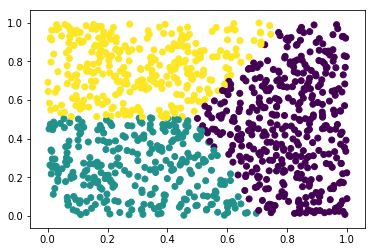

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from h1b.cluster import cluster

data = np.random.random((1000, 2))
clustering = cluster('KMeans', 3, data)
plt.scatter(data[:, 0], data[:, 1], c=clustering)

For this project, the input to the clustering was the set of job titles from the dataset, but a simple list of strings is invlaid input to the clustering algorithms. To solve this, we vectorized the job titles, transforming the list of strings into a sparse matrix of word counts. This structure is very high dimensional (`N_DIM == len(VOCAB)`) which meant

1. Caused a serious slow down in clustering (particularly in `SpectralClustering`)
2. Could not be plotted in 2D space

To remedy these, we performed a dimensionality reduction through *SVD*, similar to the example provided below:

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

data = ['CHIEF EXECUTIVE', 'SOFTWARE ENGINEER']
vec = CountVectorizer().fit_transform(data)
svd = TruncatedSVD().fit_transform(vec)